<a href="https://colab.research.google.com/github/DaryaKs/Uni/blob/master/DonaldTrumpTweets_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Donald Trump tweets using PySpark

***The code completed by a student from Higher School of Economics.***
> ***Kiseleva Daria,***
***Group MBD 191,***
***Big Data Systems***

The dataset from Kaggle about Donald Trump tweets from Twitter was used in this script.
https://www.kaggle.com/austinreese/trump-tweets

The data set was taken from the official twitter account of Donald Trump: https://twitter.com/realDonaldTrump

The script is counting top 10-20 most used words in Donald Trump tweets during 2009-2020 years.
There is a description about how to install the dependencies to use Pyspark in Colab such as Spark and Java via MAC OS.

The script is following steps from creating a DataFrame, cleaning the data and making final vizualization of top 20 most used words in official Donald Trump twitter account.

**Installing part**

In [0]:
#Installing the dependencies to use Pyspark in Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q hhttps://www.apache.org/dyn/closer.lua/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
#Spark and Java installed in Colab

In [0]:
#Setting the environment path that enables to run PySpark in Colab environment
#configured for MAC OS
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [17]:
#Checking if the path is correct by printing the path
#If there is a list of sample files, the code will initialize without any 'index out of range' errors in next steps
print(os.listdir('./sample_data'))

['anscombe.json', 'README.md', 'mnist_train_small.csv', 'california_housing_train.csv', 'mnist_test.csv', 'california_housing_test.csv']


In [18]:
#TEST CODE

#Running a local spark session to test installation:
#Simple calculations
import findspark
findspark.init()
import pyspark
import random
sc = pyspark.SparkContext(appName="Pi")
num_samples = 100000000
def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1
count = sc.parallelize(range(0, num_samples)).filter(inside).count()
pi = 4 * count / num_samples
print(pi)
sc.stop()

3.14162088


In [0]:
#Importing necessary libraries
from collections import Counter
import re

import pyspark
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from nltk.stem.snowball import SnowballStemmer

from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, ArrayType

import pyspark.sql.functions as func
from pyspark.sql.functions import *
from pyspark.ml.feature import *

import matplotlib.pyplot as plt

**Setting the Data Set**

In [0]:
spark = SparkSession.builder \
        .master("local") \
        .appName("Trump") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

In [0]:
#Creating DataFrames using a SQLContext
sc = spark.sparkContext
sqlContext = SQLContext(sc)

Adding the data set "trumptweets.csv" to Files section in Colab

In [0]:
df = sqlContext.read.format("csv") \
    .option("header", "true") \
    .option("mode", "DROPMALFORMED") \
    .load("trumptweets.csv")

In [24]:
#Printing the schema in a tree format
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- link: string (nullable = true)
 |-- content: string (nullable = true)
 |-- date: string (nullable = true)
 |-- retweets: string (nullable = true)
 |-- favorites: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- geo: string (nullable = true)



In [25]:
#Showing the content of the fist 5 rows in the DataFrame using 4 specific colomns
df.select('date','content','retweets','link').show(5, truncate = True)

+-------------------+--------------------+--------+--------------------+
|               date|             content|retweets|                link|
+-------------------+--------------------+--------+--------------------+
|2009-05-04 20:54:25|Be sure to tune i...|     500|https://twitter.c...|
|2009-05-05 03:00:10|Donald Trump will...|      33|https://twitter.c...|
|2009-05-08 15:38:08|Donald Trump read...|      12|https://twitter.c...|
|2009-05-08 22:40:15|New Blog Post: Ce...|      11|https://twitter.c...|
|2009-05-12 16:07:28|"""My persona wil...|    1399|https://twitter.c...|
+-------------------+--------------------+--------+--------------------+
only showing top 5 rows



In [26]:
#Last 5 rows in the data set with all columns in the DataFrame
df.orderBy('date', ascending=False).show(5, truncate = True)

+-------------------+--------------------+--------------------+-------------------+--------+---------+--------+--------+----+
|                 id|                link|             content|               date|retweets|favorites|mentions|hashtags| geo|
+-------------------+--------------------+--------------------+-------------------+--------+---------+--------+--------+----+
|1219076533354037249|https://twitter.c...|A great show! Che...|2020-01-20 02:57:49|    7947|    34902|       @|    null|null|
|1219066007731310593|https://twitter.c...|“In the House, th...|2020-01-20 02:16:00|   20599|    81921|   @ @ @|    null|null|
|1219053709428248576|https://twitter.c...|I was thrilled to...|2020-01-20 01:27:07|   16588|    66944|    null|       #|null|
|1219004689716412416|https://twitter.c...|Now Mini Mike Blo...|2020-01-19 22:12:20|   36239|   149571|    null|    null|null|
|1218962544372670467|https://twitter.c...|I have never seen...|2020-01-19 19:24:52|   32620|   213817|    null|    nul

The data set contains tweets from 2009 till 2020 year. Each row conatins a link to the tweet, text from it, date, number of retweets, hashtags and other information.

**Counting the number of words in the data set**

In [27]:
print('Amount of words in all Donald Trump tweets:')
print(df.withColumn('word', func.explode(func.split(func.col('content'), ' '))).count())

Amount of words in all Donald Trump tweets:
813087


**10 most popular words**

In [28]:
df.withColumn('word', func.explode(func.split(func.col('content'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .show(10)

+----+-----+
|word|count|
+----+-----+
|   @|37500|
| the|25969|
|  to|17307|
| and|13079|
|   a|11980|
|  of|11716|
|  is|11074|
|  in| 9930|
| """| 9315|
| for| 8529|
+----+-----+
only showing top 10 rows



All tweets contain words with less than 3 letters. In need to clean the data to perform interesting analytics.

**Cleaning the content of tweets**

In [0]:
# Clean text
df_clean = df.select('date','retweets','link', (lower(regexp_replace('content', "[^a-zA-Z\\s]", "")).alias('content')))

# Tokenize text
tokenizer = Tokenizer(inputCol='content', outputCol='words_token')
df_words_token = tokenizer.transform(df_clean).select('date','retweets','link', 'words_token')

# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('date','retweets','link', 'words_clean')

# Stem text
# Stemmers remove morphological affixes from words, leaving only the word stem.
#I do not need it.

#stemmer = SnowballStemmer(language='english')
#stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
#df_stemmed = df_words_no_stopw.withColumn("words_stemmed", stemmer_udf("words_clean")).select('date','retweets','link', 'words_stemmed')

# Filter length word > 3
filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
df_final_words = df_words_no_stopw.withColumn('words', filter_length_udf(col('words_clean')))

In [0]:
#Convert array string to string
df_cleaned = df_final_words.withColumn('words', concat_ws(" ", col("words")))

Showing 5 rows of the string made from the column "context" without small words like articles and prepositions.

In [31]:
df_cleaned.select('words').show(5, truncate = False)

+------------------------------------------------------------------------------------------------------+
|words                                                                                                 |
+------------------------------------------------------------------------------------------------------+
|sure tune watch donald trump late night david letterman presents top ten list tonight                 |
|donald trump appearing view tomorrow morning discuss celebrity apprentice new book think like champion|
|donald trump reads top ten financial tips late show david letterman httptinyurlcomooafwn funny        |
|new blog post celebrity apprentice finale lessons learned along way httptinyurlcomqluxe               |
|persona never wallflower rather build walls cling donald trump                                        |
+------------------------------------------------------------------------------------------------------+
only showing top 5 rows



**20 most popular LONG words**

In [36]:
df_cleaned.withColumn('word', func.explode(func.split(func.col('words'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .show(20)

+---------------+-----+
|           word|count|
+---------------+-----+
|realdonaldtrump| 8356|
|          great| 5830|
|          trump| 5364|
|      president| 2622|
|          thank| 2599|
|         people| 2363|
|         thanks| 1848|
|            new| 1786|
|            get| 1714|
|        country| 1663|
|         donald| 1663|
|           like| 1516|
|        america| 1497|
|           time| 1493|
|            big| 1492|
|           good| 1491|
|          obama| 1409|
|            one| 1404|
|           make| 1393|
|           dont| 1342|
+---------------+-----+
only showing top 20 rows



In [33]:
!pip install wordcloud

In [0]:
top_words=df_cleaned.withColumn('word', func.explode(func.split(func.col('words'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)\
    .select('word').collect()[:20]
text2=[str(row['word']) for row in top_words]
text=" ".join(text2)

**Vizualization of the result**

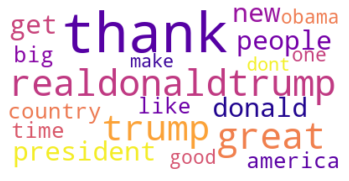

In [38]:
from wordcloud import WordCloud

wordcloud=WordCloud(stopwords=[], background_color='white', colormap='plasma', collocations=False)\
.generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.margins(x=0,y=0)
plt.show()

***Make America Great Again***

![alt text](https://i.insider.com/555246276da8114c57fe49d6?width=1100&format=jpeg&auto=webp)